In [1]:
from rosemary import jpt_in_notebook, jpt_parse_args, jpt_setup; jpt_setup()
if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[1] 
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


1
Sun Dec 17 00:38:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   27C    P0    39W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A 

In [2]:
import logging
import os
import sys
from dataclasses import dataclass, field, asdict
from typing import Optional
from functools import partial
import pyarrow
import datasets
import numpy as np

import json
import torch
from datasets import load_dataset
from collections import Counter
import transformers
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    LlamaTokenizer,
    LlamaTokenizerFast,
    CodeLlamaTokenizerFast,
    HfArgumentParser,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    set_seed,
    GPTNeoXTokenizerFast,
    GPT2Tokenizer,
    GPT2TokenizerFast, 
    OPTForCausalLM,
)
from transformers import Trainer
from peft import LoraConfig, TaskType, get_peft_model
from transformers.trainer_utils import get_last_checkpoint
logger = logging.getLogger(__name__)


## jobs submitted in notebook inherits env variables.
cache_dir = '/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/cache'
os.environ['WANDB_DIR'] = cache_dir
os.makedirs(os.environ['WANDB_DIR'], exist_ok=True)
os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_PROJECT'] = 'mitibm'
##

[2023-12-17 00:38:51,870] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
import sys
from open_instruct.finetune_trainer import ModelArguments, DataTrainingArguments, TrainingArguments
from open_instruct.finetune_trainer import encode_with_prompt_completion_format, encode_with_messages_format


In [4]:
model_name_or_path = 'results/huggyllama:llama-7b_human_mix-trainer_savebystep'
model_name_or_path = '../results/baselines/huggyllama/llama-7b'
model_name_or_path = '../results/baselines/codellama/CodeLlama-7b-hf'
model_name_or_path = '../results/baselines/NousResearch/Llama-2-7b-hf'
# model_name_or_path = 'mosaicml/mpt-7b'
# model_name_or_path = '../results/baselines/gpt2-medium'
# model_name_or_path = '../results/baselines/mistralai/Mistral-7B-v0.1'
# model_name_or_path = '../results/baselines/EleutherAI/pythia-70m'

# train_file = 'data/processed/all.jsonl'
# subsample_mixture =  {'cot': 976, 'dolly': 15, 'flan_v2': 976, 'oasst1': 34}; subsample_inds_file=None

train_file = 'data/processed/sharegpt/sharegptv2_data.jsonl'
# train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'
# train_file = 'data/processed/ultrachat/ultrachat200k_train_data.jsonl'
# train_file = 'data/processed/starcoder/starcoder_commentinstr_cleaned.jsonl'


# subsample_inds_file = os.path.join(
#     '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'
#     'note_explore_dpp_llama-7b_flan_v2_subsets_K_cos.pkl'); subsample_mixture = None
# train_file = 'data/processed/ultrachat/ultrachat_data.jsonl'
subsample_inds_file = None; subsample_mixture = None
dataloader_sampler = 'SequentialSampler' # 'RandomSampler'|'SequentialSampler'
dataloader_sampler = None

#     --use_lora \
#     --lora_rank 8 \
#     --lora_alpha 8 \
#     --lora_dropout 0.05 

save_strategy = 'steps'
save_steps = 5
save_total_limit = 1
eval_steps = save_steps
overwrite_output_dir = True # false if want to test trainer resume from dir.

#     --report_to tensorboard wandb \

cmd = f"""
    --model_name_or_path {model_name_or_path} \
    --tokenizer_name {model_name_or_path} \
    --use_fast_tokenizer True \
    --max_seq_length 2048 \
    --train_file {train_file} \
    --do_train \
    --preprocessing_num_workers 16 \
    --per_device_train_batch_size 2 \
    --gradient_accumulation_steps 128 \
    --gradient_checkpointing \
    --learning_rate 2e-5 \
    --lr_scheduler_type linear \
    --warmup_ratio 0.03 \
    --weight_decay 0. \
    
    --evaluation_strategy=steps \
    --eval_steps={eval_steps} \
    --report_to none \
    --logging_strategy=steps \
    --logging_first_step \
    --logging_steps=1 \
    --save_strategy={save_strategy} \
    --save_steps={save_steps} \
    --save_total_limit={save_total_limit} \
    
    --num_train_epochs 1 \
    --fp16 \
    --torch_dtype float32 \
    --dataloader_num_workers 8 \
    --use_flash_attn False \
    --output_dir "results/jpt_{':'.join(model_name_or_path.split('/')[-2:])}_humanmix" \
    --overwrite_output_dir {overwrite_output_dir} \
    {'--subsample_mixture="'+str(subsample_mixture).replace(': ', ':').replace(', ', ',')+'"'
        if subsample_mixture else ''} \
    {'--subsample_inds_file='+subsample_inds_file if subsample_inds_file else ''} \
    {'--dataloader_sampler '+str(dataloader_sampler) if dataloader_sampler else ''} \
"""
#    --subsample_mixture='{{"flan_v2":100000}}'

#      --subsample_mixture '{{"baize": 8333, "code_alpaca": 8333, "cot": 8333, "dolly": 8333, "flan_v2": 8333, "gpt4_alpaca": 8333, "oasst1": 8333, "self_instruct": 8333, "sharegpt": 8333, "stanford_alpaca": 8333, "super_ni": 8333, "unnatural_instructions": 8333}}'

import shlex
args = shlex.split(cmd)


parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_args_into_dataclasses(args)
# wpq: convert str to dict
if data_args.subsample_mixture is not None:
    import json
    import re
    data_args.subsample_mixture = re.compile('(?<!\\\\)\'').sub('\"', data_args.subsample_mixture)
    data_args.subsample_mixture = json.loads(data_args.subsample_mixture)
    print('subsample mixture:')
    print(data_args.subsample_mixture)
if data_args.subsample_mixture is not None and data_args.subsample_inds_file is not None:
    raise ValueError('Either use mixture proportion or exact subset indices, but not both.')
if data_args.subsample_inds_file is not None:
    if 'flan_v2' not in data_args.train_file:
        raise ValueError('subset indices only support flan_v2 for now.')

for x in [model_args, data_args, training_args]:
    print(x)
        


ModelArguments(model_name_or_path='../results/baselines/NousResearch/Llama-2-7b-hf', config_name=None, tokenizer_name='../results/baselines/NousResearch/Llama-2-7b-hf', use_flash_attn=False, cache_dir=None, use_fast_tokenizer=True, model_revision='main', token=None, use_auth_token=None, trust_remote_code=False, torch_dtype='float32', use_lora=False, lora_rank=64, lora_alpha=16, lora_dropout=0.1, load_in_8bit=False, low_cpu_mem_usage=False)
DataTrainingArguments(dataset_name=None, dataset_config_name=None, train_file='data/processed/sharegpt/sharegptv2_data.jsonl', max_train_samples=None, streaming=False, overwrite_cache=False, preprocessing_num_workers=16, max_seq_length=2048, subsample_mixture=None, subsample_inds_file=None)
TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=8,
dataloader_pin_memory=True,
data

In [5]:

# wpq: save args to a json file
with training_args.main_process_first(local=False, desc=f"Saving args to `{training_args.output_dir+'.args.json'}`"):
    args_dict = {
        'model_args': asdict(model_args),
        'data_args': asdict(data_args),
        'training_args': asdict(training_args),
    }
    args_dict_path = training_args.output_dir.strip('/')+'.args.json'
    with open(args_dict_path, 'w') as f:
        json.dump(args_dict, f)
    print(f'Saving args dict to {args_dict_path}')
    

Saving args dict to results/jpt_NousResearch:Llama-2-7b-hf_humanmix.args.json


In [6]:
# with training_args.main_process_first(local=False, desc=f"setup wandb init"):
#     if 'wandb' in training_args.report_to:
#         wandb_init_kwargs_path = os.path.join(training_args.output_dir, 'wandb_init_kwargs.json')
#         os.makedirs(training_args.output_dir, exist_ok=True)
#         if not os.path.isfile(wandb_init_kwargs_path):
#             import wandb
#             wandb_init_kwargs = {}
#             wandb_init_kwargs['project'] = os.environ['WANDB_PROJECT']
#             wandb_init_kwargs['name'] = training_args.run_name
#             wandb_init_kwargs['resume'] = 'allow' # resume if `run_id` identical to previous, otherwise start new run
#             wandb_init_kwargs['id'] = wandb.sdk.lib.runid.generate_id()
#             wandb_init_kwargs['mode'] = 'offline'
#             with open(wandb_init_kwargs_path, 'w') as f:
#                 json.dump(wandb_init_kwargs, f, indent=4)
#         else:
#             with open(wandb_init_kwargs_path, 'r') as f:
#                 wandb_init_kwargs = json.load(f)
# wandb_init_kwargs
# import wandb
# wandb.init(**wandb_init_kwargs)

In [7]:

# Detecting last checkpoint.
last_checkpoint = None
if os.path.isdir(training_args.output_dir) and training_args.do_train and not training_args.overwrite_output_dir:
    last_checkpoint = get_last_checkpoint(training_args.output_dir)
    if last_checkpoint is None and len(os.listdir(training_args.output_dir)) > 0:
        # wpq: since I do write `.json` file to output_dir, raise if there are more files.
        if len(os.listdir(training_args.output_dir))>1:
            raise ValueError(
                f"Output directory ({training_args.output_dir}) already exists and is not empty. "
                "Use --overwrite_output_dir to overcome."
            )
    elif last_checkpoint is not None and training_args.resume_from_checkpoint is None:
        logger.info(
            f"Checkpoint detected, resuming training at {last_checkpoint}. To avoid this behavior, change "
            "the `--output_dir` or add `--overwrite_output_dir` to train from scratch."
        )
        
last_checkpoint

In [8]:

# Set seed before initializing model.
set_seed(training_args.seed)


if data_args.dataset_name is not None:
    # Downloading and loading a dataset from the hub.
    raw_datasets = load_dataset(
        data_args.dataset_name,
        data_args.dataset_config_name,
        cache_dir=model_args.cache_dir,
        token=model_args.token,
        streaming=data_args.streaming,
        download_mode=datasets.GenerateMode.FORCE_REDOWNLOAD if data_args.overwrite_cache else datasets.GenerateMode.REUSE_DATASET_IF_EXISTS,
    )
else: 
    data_files = {}
    dataset_args = {}
    if data_args.train_file is not None:
        data_files["train"] = data_args.train_file
    if 'ultrachat' in data_args.train_file:
        data_files['test'] = (
            '/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/'
            'data/processed/ultrachat/ultrachat200k_test_data.jsonl')
    raw_datasets = load_dataset(
        "json",
        data_files=data_files,
        cache_dir=model_args.cache_dir,
        **dataset_args,
    )
    if 'ultrachat' in data_args.train_file:
        raw_datasets['test'] = raw_datasets['test'].select(range(1000))

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-66f58c7711af992c/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:

config_kwargs = {
    "cache_dir": model_args.cache_dir,
    "revision": model_args.model_revision,
    "use_auth_token": True if model_args.use_auth_token else None,
    "trust_remote_code": True if 'mpt' in model_args.model_name_or_path else False,
}
if model_args.config_name:
    config = AutoConfig.from_pretrained(model_args.config_name, **config_kwargs)
elif model_args.model_name_or_path:
    config = AutoConfig.from_pretrained(model_args.model_name_or_path, **config_kwargs)
    # wpq: add support for mpt models.
    if 'mpt' in model_args.model_name_or_path:
        config.attn_config['attn_impl'] = 'triton'
        config.init_device = 'cuda' # For fast initialization directly on GPU!
else:
    raise ValueError(
        "You are instantiating a new config instance from scratch. This is not supported by this finetuning script."
    )

tokenizer_kwargs = {
    "cache_dir": model_args.cache_dir,
    "use_fast": model_args.use_fast_tokenizer if 'pythia' not in model_args.model_name_or_path else True,
    "revision": model_args.model_revision,
    "use_auth_token": True if model_args.use_auth_token else None,
}
if model_args.tokenizer_name:
    tokenizer = AutoTokenizer.from_pretrained(model_args.tokenizer_name, **tokenizer_kwargs)
elif model_args.model_name_or_path:
    tokenizer = AutoTokenizer.from_pretrained(model_args.model_name_or_path, **tokenizer_kwargs)
else:
    raise ValueError(
        "You are instantiating a new tokenizer from scratch. This is not supported by this finetuning script."
    )
    
config

LlamaConfig {
  "_name_or_path": "../results/baselines/NousResearch/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.35.2",
  "use_cache": true,
  "vocab_size": 32000
}

In [10]:

if model_args.model_name_or_path:
    torch_dtype = (
        model_args.torch_dtype
        if model_args.torch_dtype in ["auto", None]
        else getattr(torch, model_args.torch_dtype)
    )
    model = AutoModelForCausalLM.from_pretrained(
        model_args.model_name_or_path,
        from_tf=bool(".ckpt" in model_args.model_name_or_path),
        config=config,
        cache_dir=model_args.cache_dir,
        revision=model_args.model_revision,
        token=model_args.token,
        trust_remote_code=model_args.trust_remote_code,
        torch_dtype=torch_dtype,
        low_cpu_mem_usage=model_args.low_cpu_mem_usage,
        use_flash_attention_2=True if model_args.use_flash_attn else False,
    )
else:
    logger.warning("No pretrained model_name_or_path is given. Training new model from scratch.")
    model = AutoModelForCausalLM.from_config(config, trust_remote_code=model_args.trust_remote_code)
    n_params = sum({p.data_ptr(): p.numel() for p in model.parameters()}.values())
    logger.info(f"Training new model from scratch - Total size={n_params/2**20:.2f}M params")
    

# wpq: `use_cache=True` is incompatible with gradient checkpointing
model.config.use_cache = True if not training_args.gradient_checkpointing else False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/transformers/src/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/transformers/src/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [11]:

# no default pad token for llama!
# here we add all special tokens again, because the default ones are not in the special_tokens_map 
if isinstance(tokenizer, (LlamaTokenizer, LlamaTokenizerFast, CodeLlamaTokenizerFast)):
    from transformers import AddedToken
    num_added_tokens = tokenizer.add_special_tokens({
        "bos_token": AddedToken("<s>", normalized=False, special=True),
        "eos_token": AddedToken("</s>", normalized=False, special=True),
        "unk_token": AddedToken("<unk>", normalized=False, special=True),
        "pad_token": AddedToken("<pad>", normalized=False, special=True),
    })
    ## wpq: for `huggyllama`/`NousResearch/Llama-2-7b-hf`, `LlamaTokenizerFast` tokenizer config not properly implemented and cannot tokenize special tokens like eos_token corretly. Need the following workaround. More details: https://github.com/huggingface/transformers/issues/23833
    if isinstance(tokenizer, LlamaTokenizerFast):
        if os.path.isdir(model_args.model_name_or_path):
            tmp_tok_path = os.path.join(
                os.path.dirname(model_args.model_name_or_path),
                os.path.basename(model_args.model_name_or_path)+'_fixtok')
            if not os.path.isdir(tmp_tok_path):
                raise ValueError(f'Not valid fixtok path: {tmp_tok_path}')
        else:
            from secrets import token_hex
            tmp_tok_path = f'/tmp/wpq_tok_{token_hex(16)}'
            tokenizer.save_pretrained(tmp_tok_path)
        tokenizer = AutoTokenizer.from_pretrained(tmp_tok_path, **tokenizer_kwargs)
    for s, s_tokenized in [
        ("Hi<s>Hey</s>sir<unk>what<pad><pad>", 
        ['▁Hi', '<s>', '▁Hey', '</s>', '▁sir', '<unk>', '▁what', '<pad>', '<pad>']),
    ]:
        assert(tokenizer.tokenize(s, add_special_tokens=False)==s_tokenized)
elif isinstance(tokenizer, GPTNeoXTokenizerFast):
    num_added_tokens = tokenizer.add_special_tokens({
        "pad_token": "<pad>",
    })
    assert num_added_tokens == 1, "GPTNeoXTokenizer should only add one special token - the pad_token."
elif isinstance(tokenizer, (GPT2Tokenizer, GPT2TokenizerFast)) and isinstance(model, OPTForCausalLM):
    num_added_tokens = tokenizer.add_special_tokens({'unk_token': '<unk>'})
elif isinstance(tokenizer, (GPT2Tokenizer, GPT2TokenizerFast)):
    num_added_tokens = tokenizer.add_special_tokens({
        "pad_token": "<pad>",
    })
    assert num_added_tokens == 1, "GPT2Tokenizer should only add one special token - the pad_token."

# resize embeddings if needed (e.g. for LlamaTokenizer)
embedding_size = model.get_input_embeddings().weight.shape[0]
if len(tokenizer) > embedding_size:
    model.resize_token_embeddings(len(tokenizer))

# wpq: use int8 training
# wpq: put this after resize embedding!
if model_args.load_in_8bit:
    from peft import prepare_model_for_int8_training
    model = prepare_model_for_int8_training(model)

In [12]:

# wpq: add peft to finetune_trainer.py
if model_args.use_lora:
    logger.info("Initializing LORA model...")
    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM, 
        inference_mode=False, 
        bias='none',
        r=model_args.lora_rank, 
        lora_alpha=model_args.lora_alpha, 
        lora_dropout=model_args.lora_dropout,
        target_modules=['q_proj','k_proj','v_proj','o_proj'],
    )
    # wpq: the following fixes `element 0 of tensors does not require grad and does not have a grad_fn` 
    # https://github.com/huggingface/peft/issues/137
    # https://github.com/huggingface/peft/issues/522
    if hasattr(training_args, 'gradient_checkpointing'):
        if training_args.gradient_checkpointing:
            model.enable_input_require_grads()

    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

In [13]:

# Preprocessing the datasets.
if "prompt" in raw_datasets["train"].column_names and "completion" in raw_datasets["train"].column_names:
    encode_function = partial(
        encode_with_prompt_completion_format,
        tokenizer=tokenizer,
        max_seq_length=data_args.max_seq_length,
    )
elif "messages" in raw_datasets["train"].column_names:
    encode_function = partial(
        encode_with_messages_format,
        tokenizer=tokenizer,
        max_seq_length=data_args.max_seq_length,
    )
else:
    raise ValueError("You need to have either 'prompt'&'completion' or 'messages' in your column names.")

raw_datasets['train'] = raw_datasets['train'].select(range(1000))
    

# To speed up this part, we use multiprocessing.
with training_args.main_process_first(local=False, desc="Processing instruction data"):
    if not data_args.streaming:
        lm_datasets = raw_datasets.map(
            encode_function,
            batched=False,
            num_proc=data_args.preprocessing_num_workers,
            load_from_cache_file=not data_args.overwrite_cache,
            desc="Tokenizing and reformatting instruction data",
        )
    else:
        lm_datasets = raw_datasets.map(
            encode_function,
            batched=False,
        )
    lm_datasets.set_format(type="pt")

if training_args.do_train:
    if "train" not in raw_datasets:
        raise ValueError("--do_train requires a train dataset")
    train_dataset = lm_datasets["train"]
    ## wpq: subsample `dataset` according to `data_args.subsample_mixture`.
    # assumes dataset in `train_file` ordered, 
    # e.g., ['cot', 'cot', 'flan_v2', 'flan_v2', ...]
    # note `counts.items()` is ordered as well!
    if data_args.subsample_mixture is not None:
        counts = Counter(train_dataset['dataset'])
        inds = []
        cum = 0
        for k, N in counts.items():
            n = int(data_args.subsample_mixture.get(k, 0))
            replace = True if n>N else False
            replace = True # always sample with replacement, for fairer comparison.
            inds += list(np.random.choice(N, size=n, replace=replace) + cum)
            cum += N
            print(k, N, n, len(inds))
        train_dataset = train_dataset.select(inds)


    if data_args.subsample_inds_file is not None:
        with open(data_args.subsample_inds_file, 'rb') as f:
            inds = pickle.load(f)['K']
        logger.info(f'Using subsample_inds_file: {data_args.subsample_inds_file}')
        logger.info(f'subsample_inds_file has {len(inds)} indices.')
        train_dataset = train_dataset.select(inds)

    ## 
    if data_args.max_train_samples is not None:
        max_train_samples = min(len(train_dataset), data_args.max_train_samples)
        train_dataset = train_dataset.select(range(max_train_samples))


Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-66f58c7711af992c/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-55b6ed986212e630_*_of_00016.arrow


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32001, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_

In [19]:
x = model.model.embed_tokens.weight

print(x.min().item(), x.mean().item(), x.max().item())

-0.13671875 -4.7392186388606206e-05 0.26171875


In [21]:
x.dtype


torch.float32

In [48]:
batch = [train_dataset[i] for i in range(3)]
batch = [{k: v for k, v in d.items() if k not in ['dataset', 'id', 'messages']} for d in batch]
out = data_collator(batch)

In [57]:
out

{'input_ids': tensor([[32000, 32000, 32000,  ...,  1820, 29889,     2],
        [    1,   529, 29989,  ..., 20026, 29889,     2],
        [32000, 32000, 32000,  ..., 31294, 30267,     2]]), 'labels': tensor([[ -100,  -100,  -100,  ...,  1820, 29889,     2],
        [ -100,  -100,  -100,  ..., 20026, 29889,     2],
        [ -100,  -100,  -100,  ..., 31294, 30267,     2]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])}

In [51]:
for i in range(3):
    print(tokenizer.decode(out['input_ids'][i]))

<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [44]:
i = 1

print(tokenizer.decode(train_dataset[i]['input_ids']))


<s> <|user|>
Summarize the main ideas of Jeff Walker's Product Launch Formula into bullet points as it pertains to a growth marketing agency implementing these strategies and tactics for their clients...
<|assistant|>
Here are the main ideas of Jeff Walker's Product Launch Formula that can be applied by a growth marketing agency for their clients:

1. Identify the target audience and their needs: Understand the ideal customer for the product or service, and create a messaging that resonates with them.
2. Pre-launch: Build anticipation and excitement for the launch by creating buzz, gathering testimonials and case studies, and using social media to create awareness.
3. Launch: Use a well-crafted launch sequence to maximize sales and conversions. This can include offering bonuses, creating scarcity, and using a deadline to create urgency.
4. Post-launch: Follow up with customers, gather feedback, and continue to provide value to keep them engaged and loyal.
5. Create a product suite: Onc

In [14]:
from open_instruct.finetune_trainer import MyTrainer

# initalize a trainer
# here we use a custom trainer that moves the model to CPU when saving the checkpoint in FSDP mode
# we can switch to the default trainer after moving to deepspeed (let's don't change too much for now)
trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset if training_args.do_train else None,
    eval_dataset=lm_datasets['test'] if (training_args.do_eval and 'test' in lm_datasets) else None,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model),
)

In [16]:
torch_dtype

torch.float32

In [41]:
xs = np.array(list(range(417)))
ys = [0.0, 0.07692307692307693, 0.15384615384615385, 0.23076923076923078, 0.3076923076923077, 0.38461538461538464, 0.46153846153846156, 0.5384615384615384, 0.6153846153846154, 0.6923076923076923, 0.7692307692307693, 0.8461538461538461, 0.9230769230769231, 1.0, 0.9975247524752475, 0.995049504950495, 0.9925742574257426, 0.9900990099009901, 0.9876237623762376, 0.9851485148514851, 0.9826732673267327, 0.9801980198019802, 0.9777227722772277, 0.9752475247524752, 0.9727722772277227, 0.9702970297029703, 0.9678217821782178, 0.9653465346534653, 0.9628712871287128, 0.9603960396039604, 0.9579207920792079, 0.9554455445544554, 0.9529702970297029, 0.9504950495049505, 0.948019801980198, 0.9455445544554455, 0.943069306930693, 0.9405940594059405, 0.9381188118811881, 0.9356435643564357, 0.9331683168316832, 0.9306930693069307, 0.9282178217821783, 0.9257425742574258, 0.9232673267326733, 0.9207920792079208, 0.9183168316831684, 0.9158415841584159, 0.9133663366336634, 0.9108910891089109, 0.9084158415841584, 0.905940594059406, 0.9034653465346535, 0.900990099009901, 0.8985148514851485, 0.8960396039603961, 0.8935643564356436, 0.8910891089108911, 0.8886138613861386, 0.8861386138613861, 0.8836633663366337, 0.8811881188118812, 0.8787128712871287, 0.8762376237623762, 0.8737623762376238, 0.8712871287128713, 0.8688118811881188, 0.8663366336633663, 0.8638613861386139, 0.8613861386138614, 0.8589108910891089, 0.8564356435643564, 0.8539603960396039, 0.8514851485148515, 0.849009900990099, 0.8465346534653465, 0.844059405940594, 0.8415841584158416, 0.8391089108910891, 0.8366336633663366, 0.8341584158415841, 0.8316831683168316, 0.8292079207920792, 0.8267326732673267, 0.8242574257425742, 0.8217821782178217, 0.8193069306930693, 0.8168316831683168, 0.8143564356435643, 0.8118811881188119, 0.8094059405940595, 0.806930693069307, 0.8044554455445545, 0.801980198019802, 0.7995049504950495, 0.7970297029702971, 0.7945544554455446, 0.7920792079207921, 0.7896039603960396, 0.7871287128712872, 0.7846534653465347, 0.7821782178217822, 0.7797029702970297, 0.7772277227722773, 0.7747524752475248, 0.7722772277227723, 0.7698019801980198, 0.7673267326732673, 0.7648514851485149, 0.7623762376237624, 0.7599009900990099, 0.7574257425742574, 0.754950495049505, 0.7524752475247525, 0.75, 0.7475247524752475, 0.745049504950495, 0.7425742574257426, 0.7400990099009901, 0.7376237623762376, 0.7351485148514851, 0.7326732673267327, 0.7301980198019802, 0.7277227722772277, 0.7252475247524752, 0.7227722772277227, 0.7202970297029703, 0.7178217821782178, 0.7153465346534653, 0.7128712871287128, 0.7103960396039604, 0.7079207920792079, 0.7054455445544554, 0.7029702970297029, 0.7004950495049505, 0.698019801980198, 0.6955445544554455, 0.693069306930693, 0.6905940594059405, 0.6881188118811881, 0.6856435643564357, 0.6831683168316832, 0.6806930693069307, 0.6782178217821783, 0.6757425742574258, 0.6732673267326733, 0.6707920792079208, 0.6683168316831684, 0.6658415841584159, 0.6633663366336634, 0.6608910891089109, 0.6584158415841584, 0.655940594059406, 0.6534653465346535, 0.650990099009901, 0.6485148514851485, 0.6460396039603961, 0.6435643564356436, 0.6410891089108911, 0.6386138613861386, 0.6361386138613861, 0.6336633663366337, 0.6311881188118812, 0.6287128712871287, 0.6262376237623762, 0.6237623762376238, 0.6212871287128713, 0.6188118811881188, 0.6163366336633663, 0.6138613861386139, 0.6113861386138614, 0.6089108910891089, 0.6064356435643564, 0.6039603960396039, 0.6014851485148515, 0.599009900990099, 0.5965346534653465, 0.594059405940594, 0.5915841584158416, 0.5891089108910891, 0.5866336633663366, 0.5841584158415841, 0.5816831683168316, 0.5792079207920792, 0.5767326732673267, 0.5742574257425742, 0.5717821782178217, 0.5693069306930693, 0.5668316831683168, 0.5643564356435643, 0.5618811881188119, 0.5594059405940595, 0.556930693069307, 0.5544554455445545, 0.551980198019802, 0.5495049504950495, 0.5470297029702971, 0.5445544554455446, 0.5420792079207921, 0.5396039603960396, 0.5371287128712872, 0.5346534653465347, 0.5321782178217822, 0.5297029702970297, 0.5272277227722773, 0.5247524752475248, 0.5222772277227723, 0.5198019801980198, 0.5173267326732673, 0.5148514851485149, 0.5123762376237624, 0.5099009900990099, 0.5074257425742574, 0.504950495049505, 0.5024752475247525, 0.5, 0.4975247524752475, 0.49504950495049505, 0.49257425742574257, 0.4900990099009901, 0.4876237623762376, 0.48514851485148514, 0.48267326732673266, 0.4801980198019802, 0.4777227722772277, 0.4752475247524752, 0.47277227722772275, 0.47029702970297027, 0.46782178217821785, 0.46534653465346537, 0.4628712871287129, 0.4603960396039604, 0.45792079207920794, 0.45544554455445546, 0.452970297029703, 0.4504950495049505, 0.44801980198019803, 0.44554455445544555, 0.4430693069306931, 0.4405940594059406, 0.4381188118811881, 0.43564356435643564, 0.43316831683168316, 0.4306930693069307, 0.4282178217821782, 0.42574257425742573, 0.42326732673267325, 0.4207920792079208, 0.4183168316831683, 0.4158415841584158, 0.41336633663366334, 0.41089108910891087, 0.4084158415841584, 0.40594059405940597, 0.4034653465346535, 0.400990099009901, 0.39851485148514854, 0.39603960396039606, 0.3935643564356436, 0.3910891089108911, 0.3886138613861386, 0.38613861386138615, 0.38366336633663367, 0.3811881188118812, 0.3787128712871287, 0.37623762376237624, 0.37376237623762376, 0.3712871287128713, 0.3688118811881188, 0.36633663366336633, 0.36386138613861385, 0.3613861386138614, 0.3589108910891089, 0.3564356435643564, 0.35396039603960394, 0.35148514851485146, 0.349009900990099, 0.3465346534653465, 0.34405940594059403, 0.3415841584158416, 0.33910891089108913, 0.33663366336633666, 0.3341584158415842, 0.3316831683168317, 0.3292079207920792, 0.32673267326732675, 0.32425742574257427, 0.3217821782178218, 0.3193069306930693, 0.31683168316831684, 0.31435643564356436, 0.3118811881188119, 0.3094059405940594, 0.3069306930693069, 0.30445544554455445, 0.30198019801980197, 0.2995049504950495, 0.297029702970297, 0.29455445544554454, 0.29207920792079206, 0.2896039603960396, 0.2871287128712871, 0.28465346534653463, 0.28217821782178215, 0.27970297029702973, 0.27722772277227725, 0.2747524752475248, 0.2722772277227723, 0.2698019801980198, 0.26732673267326734, 0.26485148514851486, 0.2623762376237624, 0.2599009900990099, 0.25742574257425743, 0.25495049504950495, 0.2524752475247525, 0.25, 0.24752475247524752, 0.24504950495049505, 0.24257425742574257, 0.2400990099009901, 0.2376237623762376, 0.23514851485148514, 0.23267326732673269, 0.2301980198019802, 0.22772277227722773, 0.22524752475247525, 0.22277227722772278, 0.2202970297029703, 0.21782178217821782, 0.21534653465346534, 0.21287128712871287, 0.2103960396039604, 0.2079207920792079, 0.20544554455445543, 0.20297029702970298, 0.2004950495049505, 0.19801980198019803, 0.19554455445544555, 0.19306930693069307, 0.1905940594059406, 0.18811881188118812, 0.18564356435643564, 0.18316831683168316, 0.1806930693069307, 0.1782178217821782, 0.17574257425742573, 0.17326732673267325, 0.1707920792079208, 0.16831683168316833, 0.16584158415841585, 0.16336633663366337, 0.1608910891089109, 0.15841584158415842, 0.15594059405940594, 0.15346534653465346, 0.15099009900990099, 0.1485148514851485, 0.14603960396039603, 0.14356435643564355, 0.14108910891089108, 0.13861386138613863, 0.13613861386138615, 0.13366336633663367, 0.1311881188118812, 0.12871287128712872, 0.12623762376237624, 0.12376237623762376, 0.12128712871287128, 0.1188118811881188, 0.11633663366336634, 0.11386138613861387, 0.11138613861386139, 0.10891089108910891, 0.10643564356435643, 0.10396039603960396, 0.10148514851485149, 0.09900990099009901, 0.09653465346534654, 0.09405940594059406, 0.09158415841584158, 0.0891089108910891, 0.08663366336633663, 0.08415841584158416, 0.08168316831683169, 0.07920792079207921, 0.07673267326732673, 0.07425742574257425, 0.07178217821782178, 0.06930693069306931, 0.06683168316831684, 0.06435643564356436, 0.06188118811881188, 0.0594059405940594, 0.05693069306930693, 0.054455445544554455, 0.05198019801980198, 0.04950495049504951, 0.04702970297029703, 0.04455445544554455, 0.04207920792079208, 0.039603960396039604, 0.03712871287128713, 0.034653465346534656, 0.03217821782178218, 0.0297029702970297, 0.027227722772277228, 0.024752475247524754, 0.022277227722772276, 0.019801980198019802, 0.017326732673267328, 0.01485148514851485, 0.012376237623762377, 0.009900990099009901, 0.007425742574257425, 0.0049504950495049506, 0.0024752475247524753]

ys = np.array(ys)*2e-5
ys

array([0.00000000e+00, 1.53846154e-06, 3.07692308e-06, 4.61538462e-06,
       6.15384615e-06, 7.69230769e-06, 9.23076923e-06, 1.07692308e-05,
       1.23076923e-05, 1.38461538e-05, 1.53846154e-05, 1.69230769e-05,
       1.84615385e-05, 2.00000000e-05, 1.99504950e-05, 1.99009901e-05,
       1.98514851e-05, 1.98019802e-05, 1.97524752e-05, 1.97029703e-05,
       1.96534653e-05, 1.96039604e-05, 1.95544554e-05, 1.95049505e-05,
       1.94554455e-05, 1.94059406e-05, 1.93564356e-05, 1.93069307e-05,
       1.92574257e-05, 1.92079208e-05, 1.91584158e-05, 1.91089109e-05,
       1.90594059e-05, 1.90099010e-05, 1.89603960e-05, 1.89108911e-05,
       1.88613861e-05, 1.88118812e-05, 1.87623762e-05, 1.87128713e-05,
       1.86633663e-05, 1.86138614e-05, 1.85643564e-05, 1.85148515e-05,
       1.84653465e-05, 1.84158416e-05, 1.83663366e-05, 1.83168317e-05,
       1.82673267e-05, 1.82178218e-05, 1.81683168e-05, 1.81188119e-05,
       1.80693069e-05, 1.80198020e-05, 1.79702970e-05, 1.79207921e-05,
      

In [54]:
llama1:
    
create_scheduler kwargs = {'lr_scheduler_type': <SchedulerType.LINEAR: 'linear'>, 'optimizer': AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
), 'num_warmup_steps': 13, 'num_training_steps': 416}

    
    
llama2: 

create_scheduler kwargs = {'lr_scheduler_type': <SchedulerType.LINEAR: 'linear'>, 'optimizer': AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 2e-05
    lr: 0.0
    weight_decay: 0.0
), 'num_warmup_steps': 13, 'num_training_steps': 416}

    create_scheduler: lr_lambda=functools.partial(<function _get_linear_schedule_with_warmup_lr_lambda at 0x7fff43850940>, 
    num_warmup_steps=13, num_training_steps=416)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32001, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_

In [55]:
trainer.optimizer

AcceleratedOptimizer (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 2e-05
    lr: 0.0
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 2e-05
    lr: 0.0
    maximize: False
    weight_decay: 0.0
)

In [45]:
166/417

create_scheduler: lr_lambda=functools.partial(<function _get_cosine_schedule_with_warmup_lr_lambda at 0x7fff426c8d30>, 
                                              num_warmup_steps=12, num_training_steps=378, num_cycles=0.5)create_scheduler: lr_lambda=functools.partial(<function _get_cosine_schedule_with_warmup_lr_lambda at 0x7fff54758d30>, num_warmup_steps=12, num_training_steps=378, num_cycles=0.5)



0.3980815347721823

In [51]:
xs = np.array(list(range(378)))
ys = np.array([0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.4166666666666667, 0.5, 0.5833333333333334, 0.6666666666666666, 0.75, 0.8333333333333334, 0.9166666666666666, 1.0, 0.999981580623855, 0.9999263238525135, 0.9998342337571565, 0.9997053171227526, 0.9995395834475577, 0.9993370449424153, 0.999097716529857, 0.9988216158430032, 0.9985087632242633, 0.9981591817238378, 0.9977728970980191, 0.9973499378072945, 0.9968903350142493, 0.99639412258127, 0.9958613370680507, 0.9952920177288985, 0.9946862065098414, 0.9940439480455385, 0.9933652896559907, 0.9926502813430544, 0.9918989757867582, 0.9911114283414204, 0.9902876970315715, 0.9894278425476789, 0.9885319282416754, 0.9876000201222912, 0.9866321868501913, 0.9856284997329157, 0.9845890327196267, 0.9835138623956602, 0.9824030679768823, 0.981256731303854, 0.9800749368358008, 0.9788577716443901, 0.9776053254073158, 0.9763176904016913, 0.9749949614972505, 0.9736372361493584, 0.9722446143918306, 0.970817198829563, 0.9693550946309721, 0.9678584095202468, 0.9663272537694112, 0.9647617401902002, 0.9631619841257475, 0.9615281034420881, 0.9598602185194733, 0.9581584522435024, 0.9564229299960678, 0.9546537796461179, 0.9528511315402357, 0.9510151184930353, 0.9491458757773765, 0.9472435411143978, 0.9453082546633702, 0.94334015901137, 0.9413393991627736, 0.9393061225285742, 0.9372404789155198, 0.9351426205150777, 0.9330127018922194, 0.930850879974034, 0.9286573140381662, 0.9264321657010799, 0.924175598906152, 0.9218877799115928, 0.9195688772781969, 0.9172190618569236, 0.9148385067763094, 0.9124273874297122, 0.9099858814623886, 0.9075141687584056, 0.9050124314273875, 0.902480853791098, 0.8999196223698598, 0.8973289258688125, 0.89470895516401, 0.8920599032883553, 0.8893819654173803, 0.8866753388548649, 0.8839402230183, 0.8811768194241951, 0.8783853316732313, 0.8755659654352599, 0.8727189284341501, 0.8698444304324835, 0.8669426832160996, 0.8640139005784924, 0.8610582983050581, 0.8580760941571967, 0.855067507856268, 0.8520327610674028, 0.8489720773831717, 0.845885682307111, 0.8427738032371077, 0.8396366694486466, 0.8364745120779165, 0.8332875641047817, 0.8300760603356159, 0.826840237386003, 0.8235803336633032, 0.8202965893490877, 0.8169892463814433, 0.813658548437147, 0.8103047409137114, 0.806928070911306, 0.8035287872145502, 0.8001071402741842, 0.796663382188616, 0.7931977666853478, 0.7897105491022818, 0.7862019863689074, 0.7826723369873714, 0.7791218610134323, 0.7755508200373, 0.7719594771643623, 0.7683480969958003, 0.7647169456090925, 0.7610662905384125, 0.7573964007549154, 0.7537075466469227, 0.75, 0.7462740339769323, 0.7425299230975981, 0.7387679432187442, 0.73498837151366, 0.7311914864517575, 0.727377567778053, 0.723546896492557, 0.7196997548295707, 0.7158364262368919, 0.7119571953549304, 0.7080623479957372, 0.7041521711219467, 0.7002269528256333, 0.696286982307086, 0.6923325498535006, 0.6883639468175926, 0.6843814655961301, 0.6803853996083917, 0.6763760432745475, 0.6723536919939669, 0.6683186421234552, 0.6642711909554174, 0.6602116366959556, 0.6561402784428974, 0.652057416163759, 0.6479633506736446, 0.6438583836130835, 0.6397428174258047, 0.635616955336455, 0.6314811013282573, 0.6273355601206143, 0.6231806371466574, 0.6190166385307427, 0.6148438710658979, 0.6106626421912162, 0.6064732599692079, 0.6022760330631005, 0.5980712707140985, 0.5938592827185993, 0.5896403794053678, 0.5854148716126721, 0.5811830706653819, 0.576945288352031, 0.572701836901845, 0.5684530289617377, 0.5641991775732755, 0.5599405961496137, 0.5556775984524044, 0.5514104985686802, 0.5471396108877122, 0.5428652500778471, 0.5385877310633232, 0.5343073690010671, 0.5300244792574742, 0.5257393773851733, 0.5214523790997773, 0.5171638002566218, 0.5128739568274944, 0.5085831648773538, 0.5042917405410435, 0.5, 0.4957082594589565, 0.4914168351226463, 0.48712604317250574, 0.48283619974337827, 0.47854762090022274, 0.4742606226148267, 0.46997552074252585, 0.46569263099893293, 0.4614122689366768, 0.4571347499221528, 0.4528603891122878, 0.44858950143131976, 0.44432240154759556, 0.4400594038503864, 0.43580082242672447, 0.43154697103826234, 0.42729816309815505, 0.42305471164796904, 0.4188169293346183, 0.414585128387328, 0.41035962059463227, 0.4061407172814008, 0.40192872928590156, 0.3977239669368997, 0.39352674003079224, 0.38933735780878376, 0.3851561289341023, 0.38098336146925726, 0.37681936285334267, 0.3726644398793857, 0.3685188986717427, 0.364383044663545, 0.3602571825741953, 0.35614161638691655, 0.35203664932635537, 0.3479425838362411, 0.3438597215571027, 0.3397883633040445, 0.33572880904458263, 0.3316813578765449, 0.3276463080060331, 0.3236239567254526, 0.3196146003916084, 0.31561853440386994, 0.3116360531824074, 0.3076674501464994, 0.30371301769291414, 0.2997730471743667, 0.2958478288780533, 0.2919376520042628, 0.2880428046450697, 0.2841635737631082, 0.28030024517042906, 0.27645310350744295, 0.27262243222194726, 0.26880851354824276, 0.2650116284863402, 0.26123205678125594, 0.257470076902402, 0.25372596602306785, 0.2500000000000001, 0.24629245335307737, 0.2426035992450848, 0.23893370946158754, 0.2352830543909074, 0.2316519030041998, 0.2280405228356377, 0.22444917996270003, 0.22087813898656772, 0.21732766301262868, 0.21379801363109258, 0.21028945089771817, 0.2068022333146522, 0.20333661781138407, 0.19989285972581594, 0.19647121278544993, 0.19307192908869397, 0.1896952590862886, 0.1863414515628531, 0.18301075361855673, 0.17970341065091244, 0.17641966633669703, 0.17315976261399696, 0.16992393966438407, 0.1667124358952184, 0.16352548792208355, 0.16036333055135343, 0.1572261967628923, 0.15411431769288908, 0.15102792261682813, 0.1479672389325971, 0.14493249214373222, 0.14192390584280346, 0.1389417016949419, 0.13598609942150763, 0.13305731678390048, 0.13015556956751667, 0.12728107156585, 0.12443403456474017, 0.12161466832676887, 0.11882318057580488, 0.1160597769817, 0.11332466114513512, 0.11061803458261976, 0.10794009671164484, 0.10529104483599022, 0.10267107413118742, 0.10008037763014033, 0.09751914620890206, 0.09498756857261242, 0.09248583124159437, 0.09001411853761149, 0.08757261257028776, 0.08516149322369054, 0.08278093814307635, 0.08043112272180308, 0.07811222008840718, 0.07582440109384808, 0.07356783429892022, 0.0713426859618338, 0.0691491200259659, 0.06698729810778065, 0.06485737948492237, 0.06275952108448019, 0.060693877471425906, 0.05866060083722624, 0.05665984098862992, 0.05469174533662979, 0.05275645888560232, 0.05085412422262364, 0.04898488150696467, 0.04714886845976429, 0.04534622035388214, 0.04357707000393224, 0.04184154775649768, 0.04013978148052677, 0.038471896557912, 0.036838015874252505, 0.03523825980979989, 0.0336727462305888, 0.032141590479753235, 0.03064490536902792, 0.02918280117043709, 0.02775538560816937, 0.02636276385064157, 0.025005038502749488, 0.02368230959830875, 0.022394674592684183, 0.02114222835560986, 0.01992506316419912, 0.018743268696145954, 0.017596932023117684, 0.016486137604339812, 0.015410967280373222, 0.014371500267084336, 0.013367813149808727, 0.012399979877708744, 0.011468071758324594, 0.010572157452321096, 0.009712302968428566, 0.008888571658579703, 0.008101024213241825, 0.007349718656945503, 0.006634710344009254, 0.005956051954461472, 0.005313793490158536, 0.0047079822711015296, 0.004138662931949255, 0.0036058774187299747, 0.0031096649857508263, 0.0026500621927054713, 0.0022271029019809707, 0.001840818276162226, 0.0014912367757366485, 0.0011783841569968367, 0.0009022834701429838, 0.0006629550575847354, 0.00046041655244233315, 0.0002946828772473764, 0.00016576624284347918, 7.36761474865455e-05, 1.841937614505129e-05])
ys = 2e-5*ys
ys

array([0.00000000e+00, 1.66666667e-06, 3.33333333e-06, 5.00000000e-06,
       6.66666667e-06, 8.33333333e-06, 1.00000000e-05, 1.16666667e-05,
       1.33333333e-05, 1.50000000e-05, 1.66666667e-05, 1.83333333e-05,
       2.00000000e-05, 1.99996316e-05, 1.99985265e-05, 1.99966847e-05,
       1.99941063e-05, 1.99907917e-05, 1.99867409e-05, 1.99819543e-05,
       1.99764323e-05, 1.99701753e-05, 1.99631836e-05, 1.99554579e-05,
       1.99469988e-05, 1.99378067e-05, 1.99278825e-05, 1.99172267e-05,
       1.99058404e-05, 1.98937241e-05, 1.98808790e-05, 1.98673058e-05,
       1.98530056e-05, 1.98379795e-05, 1.98222286e-05, 1.98057539e-05,
       1.97885569e-05, 1.97706386e-05, 1.97520004e-05, 1.97326437e-05,
       1.97125700e-05, 1.96917807e-05, 1.96702772e-05, 1.96480614e-05,
       1.96251346e-05, 1.96014987e-05, 1.95771554e-05, 1.95521065e-05,
       1.95263538e-05, 1.94998992e-05, 1.94727447e-05, 1.94448923e-05,
       1.94163440e-05, 1.93871019e-05, 1.93571682e-05, 1.93265451e-05,
      

(0.0, 417.0)

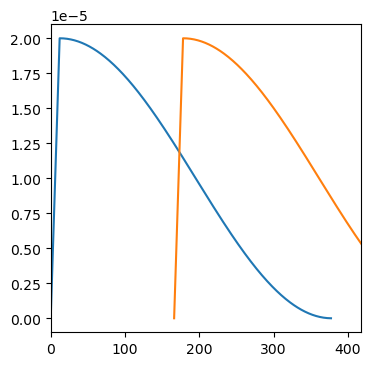

In [50]:
# s = trainer.lr_scheduler
# # s.num_warmup_steps, s.num_training_steps

# lr_lambda = s.lr_lambdas[0]



# xs = np.linspace(0, 7, 100)
# ys = np.array(list(lr_lambda(x) for x in xs))


import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.plot(xs, ys)
ax.plot(xs+166, ys)
ax.set_xlim((0, 417))




In [44]:
ys[417-166]

8.217821782178218e-06

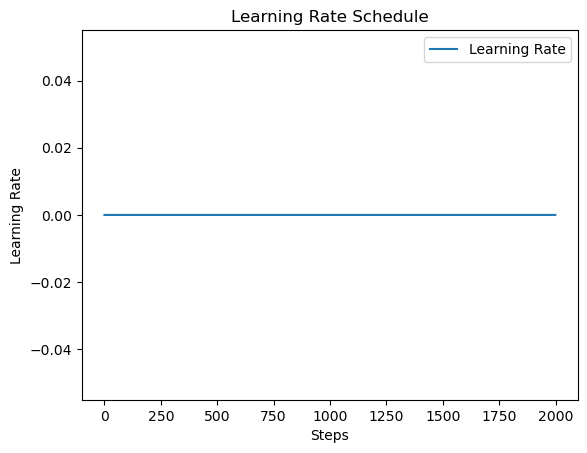

In [82]:
import matplotlib.pyplot as plt
scheduler = trainer.lr_scheduler
optimizer = trainer.optimizer

learning_rates = []
steps = []
# Training loop
total_steps = 2000  # Adjust as needed
for step in range(total_steps):
    # Your training code here

    # Step the scheduler
    scheduler.step()

    # Store learning rate and step
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    steps.append(step)

# Plotting
plt.plot(steps, learning_rates, label='Learning Rate')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()



In [15]:
checkpoint = None
if training_args.resume_from_checkpoint is not None:
    checkpoint = training_args.resume_from_checkpoint
elif last_checkpoint is not None:
    checkpoint = last_checkpoint
train_result = trainer.train(resume_from_checkpoint=checkpoint)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using t

OutOfMemoryError: CUDA out of memory. Tried to allocate 508.00 MiB (GPU 0; 31.75 GiB total capacity; 29.75 GiB already allocated; 674.88 MiB free; 30.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [88]:
!cd .. && python open_instruct/reformat_datasets.py --raw_data_dir data/raw_train --output_dir data/processed --dataset starcoder


Processing starcoder data...


In [90]:
from note_pruning_analysis import get_dataset

dss = get_dataset('starcoder_simple')
dsr = get_dataset('starcoder_role')


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-81508a354854d02d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-122cd053399382de/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


In [98]:
# instrs = list(zip(
#     [x[0]['content'] for x in dss[:100]['messages']],
#     [x[0]['content'] for x in dsr[:100]['messages']],
# ))

In [102]:
for i in range(20):
    print('\nsimple:\n')
    print('user:\n')
    messages = dss[i]['messages']
    print(messages[0]['content'])
    print('assistant:\n')
    print(messages[1]['content'])
    print('\nrole:\n')
    print('user:\n')
    messages = dsr[i]['messages']
    print(messages[0]['content'])
    print('assistant:\n')
#     print(messages[1]['content'])
    
    print('\n\n\n\n\n')


simple:

user:

Task: Implement a convolutional neural network (CNN) for image classification using Keras. The model should use CIFAR-10 dataset, which consists of 50,000 training images and 10,000 testing images. The aim is to classify the images into 10 different classes. The layers of the model should include Conv2D, Activation, MaxPooling2D, Dropout, and Dense. The activation function should be relu in the first two Conv2D layers and softmax in the last Dense layer. The optimizer should be RMSprop with a learning rate of 0.0001 and a decay of 1e-6. The loss function should be categorical crossentropy. The model should train for 100 epochs and should be evaluated on the test set.


assistant:

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 32
num_classes = 10
epochs = 100

# The data, spli

In [ ]:

trainer.save_model()  # Saves the tokenizer too for easy upload

metrics = train_result.metrics

max_train_samples = (
    data_args.max_train_samples if data_args.max_train_samples is not None else len(train_dataset)
)
metrics["train_samples"] = min(max_train_samples, len(train_dataset))

trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

In [ ]:
wandb.finish()